In [ ]:
!pip install -U torch torchvision

     |██████████████████████████████▎ | 834.1 MB 1.4 MB/s eta 0:00:34tcmalloc: large alloc 1147494400 bytes == 0x55fe5c296000 @  0x7f9955b98615 0x55fdf77034cc 0x55fdf77e347a 0x55fdf77062ed 0x55fdf77f7e1d 0x55fdf7779e99 0x55fdf77749ee 0x55fdf7707bda 0x55fdf7779d00 0x55fdf77749ee 0x55fdf7707bda 0x55fdf7776737 0x55fdf77f8c66 0x55fdf7775daf 0x55fdf77f8c66 0x55fdf7775daf 0x55fdf77f8c66 0x55fdf7775daf 0x55fdf7708039 0x55fdf774b409 0x55fdf7706c52 0x55fdf7779c25 0x55fdf77749ee 0x55fdf7707bda 0x55fdf7776737 0x55fdf77749ee 0x55fdf7707bda 0x55fdf7775915 0x55fdf7707afa 0x55fdf7775c0d 0x55fdf77749ee
     |████████████████████████████████| 881.9 MB 16 kB/s 
     |████████████████████████████████| 23.3 MB 55.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvisi

In [ ]:
from os.path import exists
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!pip install Pillow

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 1.7 MB 5.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 58 kB 3.0 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=0a76a9ac28f6438bba39171526ec1e9b2d8c17b6f5c9757424ade34fd3776223
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle


In [ ]:
import os
import PIL
print(PIL.__version__)

os.environ['KAGGLE_USERNAME'] = 'ilyanevolov'
os.environ['KAGGLE_KEY'] = 'f203dab7dbab37375ebda4da4fa14ee6'

!kaggle competitions download -c journey-springfield


7.1.2
 98% 508M/521M [00:04<00:00, 158MB/s]
100% 521M/521M [00:04<00:00, 132MB/s]


In [ ]:
!unzip -qq journey-springfield.zip

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Dec 19 19:06:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    31W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import pickle
import numpy as np
from skimage import io
from sklearn.metrics import f1_score

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image = transforms.RandomHorizontalFlip()(image)  # Добавим случайный флип по горизонту. По прошествии нескольких эпох, будут варианты как с исходным вариантом, так и с перевернутым, что позволит увеличить количество данных вдвое
        image.load() 
        
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
         
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.dropout = nn.Dropout(p=0.5) # посмотрим как покажет себя дропаут.Плохо показал
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8), #обмажемся бачнормом по всем конволюшн слоям
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16), # и тут
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32), # и здесь
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64), # и вот тут
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96), # ну и туточки не забудем. Кстати, нифига не быстрее обучение проходит
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        #self.fc1 = nn.Linear(96 * 5 * 5, 48) # добавим один промежуточный слой, что бы между ними впихнуть дропаут
        #self.out = nn.Linear(48, n_classes)
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = x.view(x.size(0), -1)
        #x = self.dropout(F.relu(self.fc1(x))) # Юзанём дропаут. Пока без него результат на каггле выше на 0,027. Оставлю без него
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False) # Вместо б-гомерзкого Адама, прикрутим AdamW с набором параметров для него
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

Проведём обучение и взглянем на наши результаты

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=15, batch_size=64) # зафигачим 6 эпох, вместо 2-х. Это чуть повысит скор явно

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.3357195556344132


epoch:   7%|▋         | 1/15 [03:04<43:09, 184.96s/it]


Epoch 001 train_loss: 0.3357     val_loss 0.7011 train_acc 0.9044 val_acc 0.8344
loss 0.26081609503654424


epoch:  13%|█▎        | 2/15 [06:09<40:03, 184.90s/it]


Epoch 002 train_loss: 0.2608     val_loss 0.6967 train_acc 0.9260 val_acc 0.8347
loss 0.22689552734881172


epoch:  20%|██        | 3/15 [09:14<36:56, 184.68s/it]


Epoch 003 train_loss: 0.2269     val_loss 0.7394 train_acc 0.9332 val_acc 0.8372
loss 0.19200660118810522


epoch:  27%|██▋       | 4/15 [12:20<33:59, 185.37s/it]


Epoch 004 train_loss: 0.1920     val_loss 0.7313 train_acc 0.9442 val_acc 0.8527
loss 0.16172913883881126


epoch:  33%|███▎      | 5/15 [15:26<30:56, 185.60s/it]


Epoch 005 train_loss: 0.1617     val_loss 0.7769 train_acc 0.9515 val_acc 0.8414
loss 0.15114943933849334


epoch:  40%|████      | 6/15 [18:34<27:57, 186.40s/it]


Epoch 006 train_loss: 0.1511     val_loss 0.8409 train_acc 0.9540 val_acc 0.8458
loss 0.1240050434853607


epoch:  47%|████▋     | 7/15 [21:40<24:50, 186.32s/it]


Epoch 007 train_loss: 0.1240     val_loss 0.8623 train_acc 0.9631 val_acc 0.8506
loss 0.11348340234009884


epoch:  53%|█████▎    | 8/15 [24:47<21:45, 186.49s/it]


Epoch 008 train_loss: 0.1135     val_loss 0.8303 train_acc 0.9645 val_acc 0.8475
loss 0.10179828966343261


epoch:  60%|██████    | 9/15 [27:55<18:40, 186.77s/it]


Epoch 009 train_loss: 0.1018     val_loss 0.8998 train_acc 0.9682 val_acc 0.8485
loss 0.10686638609188541


epoch:  67%|██████▋   | 10/15 [31:02<15:35, 187.10s/it]


Epoch 010 train_loss: 0.1069     val_loss 1.0099 train_acc 0.9660 val_acc 0.8368
loss 0.09946434199193062


epoch:  73%|███████▎  | 11/15 [34:08<12:26, 186.59s/it]


Epoch 011 train_loss: 0.0995     val_loss 0.8517 train_acc 0.9704 val_acc 0.8452
loss 0.09426042809631575


epoch:  80%|████████  | 12/15 [37:12<09:17, 185.85s/it]


Epoch 012 train_loss: 0.0943     val_loss 0.9142 train_acc 0.9720 val_acc 0.8422
loss 0.07485428967961216


epoch:  87%|████████▋ | 13/15 [40:16<06:10, 185.19s/it]


Epoch 013 train_loss: 0.0749     val_loss 0.9765 train_acc 0.9768 val_acc 0.8603
loss 0.08665068427752033


epoch:  93%|█████████▎| 14/15 [43:19<03:04, 184.73s/it]


Epoch 014 train_loss: 0.0867     val_loss 1.0259 train_acc 0.9744 val_acc 0.8502
loss 0.08014304171760007


epoch: 100%|██████████| 15/15 [46:23<00:00, 185.55s/it]


Epoch 015 train_loss: 0.0801     val_loss 0.8805 train_acc 0.9765 val_acc 0.8575


Перед этим обучением было ещё одно на 6 эпох. Показалось, что можно ещё поучить и результат улучшится. Итого 21 эпоха обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

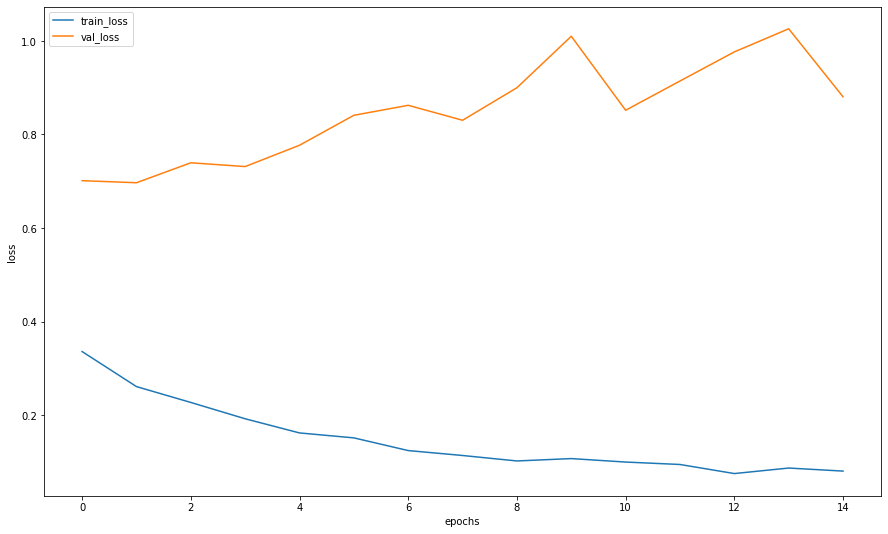

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Судя по высокому значению валид лосса получилось преобучение

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 1000))) # Попробуем пройтись сразу по всему датасету, сменим последнюю цифру на 1000
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb')) # Тоже хз, нафига нам это

In [ ]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]

 #preds_class = [label_encoder.classes_[i] for i in y_pred] # нафига эта строка нужна не ясно

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, list(y_pred), average='weighted')

0.9079911697537552

In [ ]:
def preds_f1(model, epochs=1000):
    random_characters = int(np.random.uniform(0,1000))
    ex_img, true_label = val_dataset[random_characters]
    probs_im = predict_one_sample(model, ex_img.unsqueeze(0))
    idxs = list(map(int, np.random.uniform(0,1000, epochs))) # Попробуем пройтись сразу по всему датасету, сменим последнюю цифру на 1000
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims,-1)
    actual_labels = [val_dataset[id][1] for id in idxs]
    

    return f1_score(actual_labels, list(y_pred), average='weighted')

In [ ]:
preds_f1(simple_cnn, 1000)

0.9034028719035377

In [ ]:
#Визуализация результатов предыдущих
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
#Сабмит
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

! ls 

import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv("/content/simple_cnn_submission.csv", index=False)

characters_illustration.png  label_encoder.pkl	    testset
drive			     sample_data	    train
journey-springfield.zip      sample_submission.csv


Что бы не забыть, что я тут нахуевертил
1. Увеличил число эпох обучения до 6 (скор увеличился), пробуем ещё больше увеличить
2. добавил батч нормы на всех конволюшн слоях (скор фактически не изменился, но ниже не стал)
3. Изменил оптимизатор на AdamW - скор подрос
4. Добавил дроп-аут, делает хуже, отключил
5. Добавил аугментацию. Скор вырос

Итого, спустя 21 эпоху, скор на каггле получился 0.94686! Это внезапно лучший результат!

Теперь надо приебенить ResNet


Ну что, приебеним ResNet

In [ ]:
import torchvision.models as models

res_net = models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
for param in res_net.parameters():
    param.requires_grad = False
num_ftrs = res_net.fc.in_features
res_net.fc = nn.Linear(num_ftrs, n_classes)


In [ ]:
n_classes = len(np.unique(train_val_labels))
res_net = res_net.to(DEVICE)

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=res_net, epochs=12, batch_size=64)

epoch:   0%|          | 0/12 [00:00<?, ?it/s]

loss 1.8923413160538414


epoch:   8%|▊         | 1/12 [05:18<58:23, 318.48s/it]


Epoch 001 train_loss: 1.8923     val_loss 1.3314 train_acc 0.5436 val_acc 0.6605
loss 1.1075233692796043


epoch:  17%|█▋        | 2/12 [10:03<49:49, 298.93s/it]


Epoch 002 train_loss: 1.1075     val_loss 1.0671 train_acc 0.7197 val_acc 0.7272
loss 0.9054669478879824


epoch:  25%|██▌       | 3/12 [14:46<43:43, 291.48s/it]


Epoch 003 train_loss: 0.9055     val_loss 0.9483 train_acc 0.7613 val_acc 0.7537
loss 0.7960832482371727


epoch:  33%|███▎      | 4/12 [19:29<38:24, 288.05s/it]


Epoch 004 train_loss: 0.7961     val_loss 0.9625 train_acc 0.7871 val_acc 0.7428
loss 0.7349843802638278


epoch:  42%|████▏     | 5/12 [24:13<33:26, 286.61s/it]


Epoch 005 train_loss: 0.7350     val_loss 0.9258 train_acc 0.8009 val_acc 0.7488
loss 0.6827437670847908


epoch:  50%|█████     | 6/12 [28:56<28:32, 285.43s/it]


Epoch 006 train_loss: 0.6827     val_loss 0.8952 train_acc 0.8131 val_acc 0.7572
loss 0.6447841494817993


epoch:  58%|█████▊    | 7/12 [33:42<23:48, 285.64s/it]


Epoch 007 train_loss: 0.6448     val_loss 0.8432 train_acc 0.8225 val_acc 0.7728
loss 0.60549772496861


epoch:  67%|██████▋   | 8/12 [38:25<18:59, 284.79s/it]


Epoch 008 train_loss: 0.6055     val_loss 0.8252 train_acc 0.8314 val_acc 0.7778
loss 0.5798122583775697


epoch:  75%|███████▌  | 9/12 [43:07<14:12, 284.10s/it]


Epoch 009 train_loss: 0.5798     val_loss 0.8310 train_acc 0.8378 val_acc 0.7789
loss 0.5627144245108462


epoch:  83%|████████▎ | 10/12 [47:53<09:29, 284.63s/it]


Epoch 010 train_loss: 0.5627     val_loss 0.8185 train_acc 0.8441 val_acc 0.7767
loss 0.5361693515937961


epoch:  92%|█████████▏| 11/12 [52:42<04:45, 285.77s/it]


Epoch 011 train_loss: 0.5362     val_loss 0.7968 train_acc 0.8483 val_acc 0.7881
loss 0.5215004965737942


epoch: 100%|██████████| 12/12 [57:26<00:00, 287.19s/it]


Epoch 012 train_loss: 0.5215     val_loss 0.7741 train_acc 0.8547 val_acc 0.7944


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

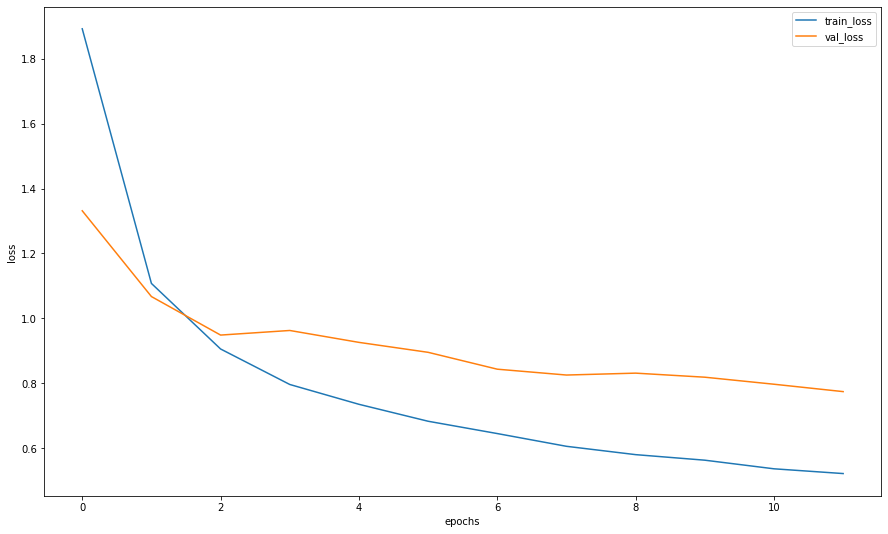

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Переобучения нет, но и выдающихся результатов не обнаружено

In [ ]:
preds_f1(res_net, 1000)

0.8788942370102887

In [ ]:
#Сабмит
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(res_net, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

! ls 

import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv("/content/res_net_submission.csv", index=False)

characters_illustration.png  label_encoder.pkl	    simple_cnn_submission.csv
drive			     sample_data	    testset
journey-springfield.zip      sample_submission.csv  train


ResNet прошлый раз дал скор на сабмите всего 0,77! Сейчас 0.78746. Результат не впечатляющий

Теперь попробуем AlexNet

In [ ]:
import torchvision.models as models
model_alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
for param in model_alexnet.features.parameters():
    param.requires_grad = False
num_in_features = 4096
num_out_features = len(np.unique(train_val_labels))
model_alexnet.classifier[6] = nn.Linear(in_features=num_in_features, out_features=num_out_features, bias=True)

In [ ]:
model_alexnet.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()

history = train(train_dataset, val_dataset, model=model_alexnet, epochs=15, batch_size = 64)


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 1.748564579060248


epoch:   7%|▋         | 1/15 [03:09<44:10, 189.34s/it]


Epoch 001 train_loss: 1.7486     val_loss 1.2116 train_acc 0.5444 val_acc 0.6932
loss 0.821333055652185


epoch:  13%|█▎        | 2/15 [06:11<40:05, 185.06s/it]


Epoch 002 train_loss: 0.8213     val_loss 0.8657 train_acc 0.7769 val_acc 0.7684
loss 0.5205121202539946


epoch:  20%|██        | 3/15 [09:13<36:45, 183.76s/it]


Epoch 003 train_loss: 0.5205     val_loss 0.8599 train_acc 0.8570 val_acc 0.7820
loss 0.37553791092325833


epoch:  27%|██▋       | 4/15 [12:15<33:33, 183.01s/it]


Epoch 004 train_loss: 0.3755     val_loss 0.9010 train_acc 0.8927 val_acc 0.7870
loss 0.2738696708867099


epoch:  33%|███▎      | 5/15 [15:17<30:25, 182.57s/it]


Epoch 005 train_loss: 0.2739     val_loss 1.0629 train_acc 0.9206 val_acc 0.7652
loss 0.22512516279882425


epoch:  40%|████      | 6/15 [18:17<27:17, 181.91s/it]


Epoch 006 train_loss: 0.2251     val_loss 0.9683 train_acc 0.9346 val_acc 0.7906
loss 0.23729957698687937


epoch:  47%|████▋     | 7/15 [21:19<24:13, 181.64s/it]


Epoch 007 train_loss: 0.2373     val_loss 1.2279 train_acc 0.9333 val_acc 0.7698
loss 0.18700546651169314


epoch:  53%|█████▎    | 8/15 [24:19<21:09, 181.33s/it]


Epoch 008 train_loss: 0.1870     val_loss 1.0596 train_acc 0.9465 val_acc 0.7994
loss 0.18409718684123627


epoch:  60%|██████    | 9/15 [27:19<18:04, 180.83s/it]


Epoch 009 train_loss: 0.1841     val_loss 1.0649 train_acc 0.9502 val_acc 0.7969
loss 0.13916455789583262


epoch:  67%|██████▋   | 10/15 [30:19<15:02, 180.52s/it]


Epoch 010 train_loss: 0.1392     val_loss 1.5064 train_acc 0.9590 val_acc 0.7514
loss 0.17208520390287432


epoch:  73%|███████▎  | 11/15 [33:20<12:02, 180.68s/it]


Epoch 011 train_loss: 0.1721     val_loss 1.3798 train_acc 0.9548 val_acc 0.7956
loss 0.17685893238911574


epoch:  80%|████████  | 12/15 [36:20<09:01, 180.59s/it]


Epoch 012 train_loss: 0.1769     val_loss 1.3150 train_acc 0.9542 val_acc 0.7971
loss 0.14212437522211355


epoch:  87%|████████▋ | 13/15 [39:21<06:01, 180.54s/it]


Epoch 013 train_loss: 0.1421     val_loss 1.3641 train_acc 0.9622 val_acc 0.7917
loss 0.13980071830274163


epoch:  93%|█████████▎| 14/15 [42:20<03:00, 180.36s/it]


Epoch 014 train_loss: 0.1398     val_loss 1.3225 train_acc 0.9646 val_acc 0.8109
loss 0.1292875545276518


epoch: 100%|██████████| 15/15 [45:20<00:00, 181.39s/it]


Epoch 015 train_loss: 0.1293     val_loss 1.4258 train_acc 0.9687 val_acc 0.8013


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

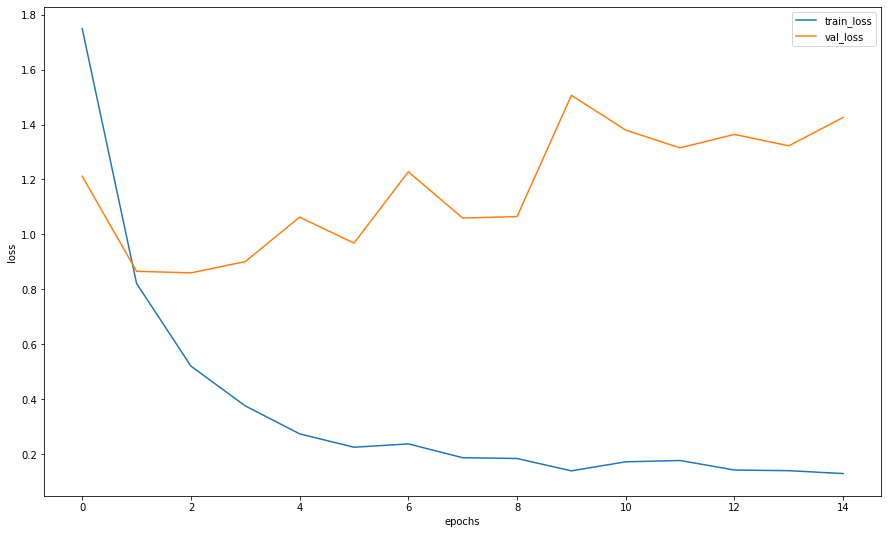

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Снова график выглядит так, будто есть переобучение. Но рост валид лосса начался с 3-й эпохи, что странно

In [ ]:
preds_f1(model_alexnet, 1000)

0.8577827003987529

In [ ]:
#Сабмит
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_alexnet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

! ls 

import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv("/content/alexnet_submission.csv", index=False)

characters_illustration.png  res_net_submission.csv	testset
drive			     sample_data		train
journey-springfield.zip      sample_submission.csv
label_encoder.pkl	     simple_cnn_submission.csv


АлексНет дал на каггле скор - 0.90754

Реснет - 0.78746

Симплнет - 0.94686